In [1]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

Using TensorFlow backend.


In [2]:
# Handcrafted Function Definition
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
def minmax_normalize_columnwise(input_np):
    output_np = np.zeros((input_np.shape[0], input_np.shape[1]))
    for c in range(input_np.shape[1]):
        col_min, col_max = np.min(input_np[:, c]), np.max(input_np[:, c])
        output_np[:, c] = input_np[:, c]
        output_np[:, c] -= col_min
        output_np[:, c] /= (col_max-col_min)
    return output_np
def sliding_window_np(input_np, window_size, stride):
    n_window = input_np.shape[0]-window_size+1
    X_output, Y_output = np.zeros((input_np.shape[0], window_size, input_np.shape[1])), np.zeros((input_np.shape[0], ))
    for r in range(n_window-1):
        X_output[r] = input_np[r:r+window_size]
        Y_output[r] = input_np[r+window_size, -1]
    return X_output, Y_output

1H
(10461, 20) (4184, 20) (6277, 20)
(21121, 40, 20) (21121,)
(14784, 40, 20) (14784,)
(6337, 40, 20) (6337,)


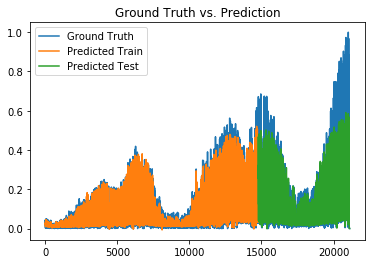

Train loss: 0.0007, Test loss: 0.0021
2H
(10461, 20) (4184, 20) (6277, 20)
(10561, 40, 20) (10561,)
(7392, 40, 20) (7392,)
(3169, 40, 20) (3169,)


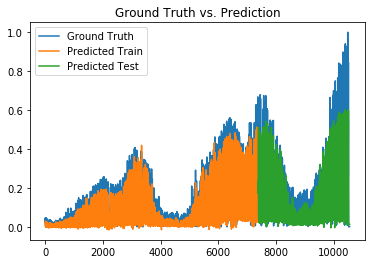

Train loss: 0.0013, Test loss: 0.0039
3H
(10461, 20) (4184, 20) (6277, 20)
(7041, 40, 20) (7041,)
(4928, 40, 20) (4928,)
(2113, 40, 20) (2113,)


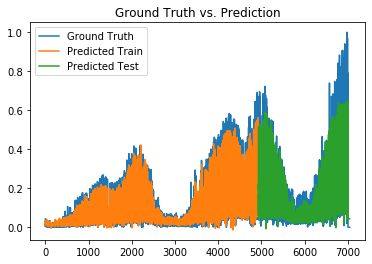

Train loss: 0.0018, Test loss: 0.0047
4H
(10461, 20) (4184, 20) (6277, 20)
(5281, 40, 20) (5281,)
(3696, 40, 20) (3696,)
(1585, 40, 20) (1585,)


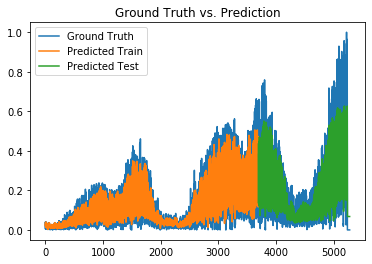

Train loss: 0.0029, Test loss: 0.0078
5H
(10461, 20) (4184, 20) (6277, 20)
(4225, 40, 20) (4225,)
(2957, 40, 20) (2957,)
(1268, 40, 20) (1268,)


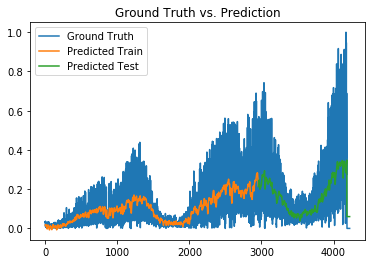

Train loss: 0.0074, Test loss: 0.0202
6H
(10461, 20) (4184, 20) (6277, 20)
(3521, 40, 20) (3521,)
(2464, 40, 20) (2464,)
(1057, 40, 20) (1057,)


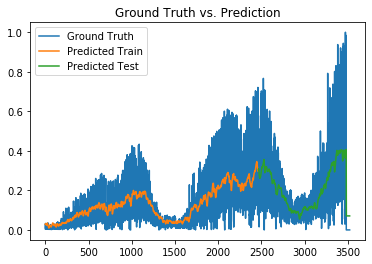

Train loss: 0.0101, Test loss: 0.0235
7H
(10461, 20) (4184, 20) (6277, 20)
(3018, 40, 20) (3018,)
(2112, 40, 20) (2112,)
(906, 40, 20) (906,)


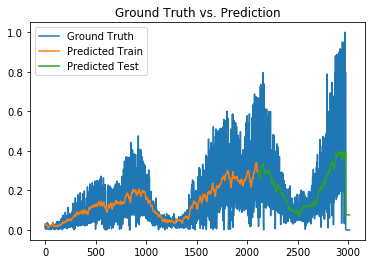

Train loss: 0.0089, Test loss: 0.0221
8H
(10461, 20) (4184, 20) (6277, 20)
(2641, 40, 20) (2641,)
(1848, 40, 20) (1848,)
(793, 40, 20) (793,)


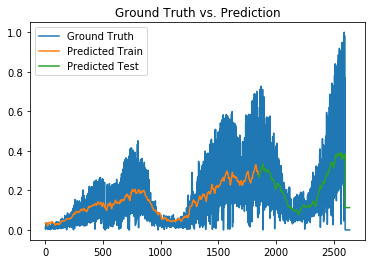

Train loss: 0.0107, Test loss: 0.0260
9H
(10461, 20) (4184, 20) (6277, 20)
(2347, 40, 20) (2347,)
(1642, 40, 20) (1642,)
(705, 40, 20) (705,)


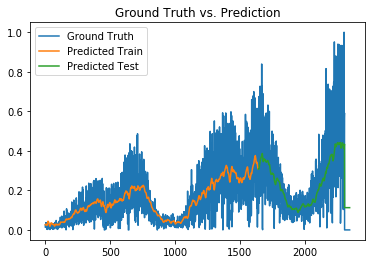

Train loss: 0.0089, Test loss: 0.0221
10H
(10461, 20) (4184, 20) (6277, 20)
(2113, 40, 20) (2113,)
(1479, 40, 20) (1479,)
(634, 40, 20) (634,)


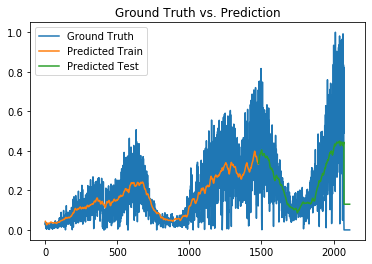

Train loss: 0.0099, Test loss: 0.0243


In [50]:
def minmax_normalize_columnwise(input_pd):
    output_np = np.zeros((input_pd.shape[0], input_pd.shape[1]))
    for c in range(input_pd.shape[1]):
        col_min, col_max = np.min(input_pd.iloc[:, c]), np.max(input_pd.iloc[:, c])
        output_np[:, c] = input_pd.iloc[:, c]
        output_np[:, c] -= col_min
        output_np[:, c] /= (col_max-col_min)
    return output_np
time_resolution = range(1, 11)
for tr in time_resolution:
    tr = str(tr)+'H'
    print(tr)
    # Load Dataset
    train, validation, test = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_train_timeseries.pkl'), pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_val_timeseries.pkl'), pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_test_timeseries.pkl')
    print(train.shape, validation.shape, test.shape)
    # Normalize Dataset
    dataset = pd.concat((train, validation, test), axis=0)
    dataset = dataset.resample(tr).sum()
    dataset_norm = minmax_normalize_columnwise(dataset)
    # Preprocessing: Sliding-window
    window_size = 40
    n_window = dataset.shape[0]-window_size+1
    X, Y = np.zeros((dataset.shape[0], window_size, dataset.shape[1])), np.zeros((dataset.shape[0],))
    for r in range(n_window-1):
        X[r], Y[r] = dataset_norm[r:r+window_size], dataset_norm[r+window_size, -1]
    print(X.shape, Y.shape)
    # Split Tr, Te
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    # Build Deeper Model
    c_input = Input(shape=(X.shape[1],X.shape[2]))
    H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
    H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
    H = TimeDistributed(MaxPooling1D(2))(H)
    H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
    H = TimeDistributed(MaxPooling1D(2))(H)
    H = TimeDistributed(Flatten())(H)
    H = Dropout(0.75)(H)
    H = CuDNNLSTM(128, return_sequences=True)(H)
    H = CuDNNLSTM(128, return_sequences=False)(H)
    H = Dropout(0.75)(H)
    H = Dense(128, activation='tanh')(H)
    H = Dense(64, activation='tanh')(H)
    c_output = Dense(1, activation='tanh')(H)
    model_cnn_lstm = Model(c_input, c_output)
#     model_cnn_lstm.summary()
    model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
    model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])
    # Train Model
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
    train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=500, callbacks=[es], verbose=0, shuffle=True)
    # Validation
    # Curve
#     plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
#     plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
    # Prediction
    Y_train_hat = model_cnn_lstm.predict(X_train, batch_size=500)
    Y_test_hat = model_cnn_lstm.predict(X_test, batch_size=500)
    plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
    plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
    plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
    plt.legend(loc='upper left')
    plt.title('Ground Truth vs. Prediction')
    plt.show()
    print("Train loss: %.4f, Test loss: %.4f" %(train_history.history['loss'][-1], train_history.history['val_loss'][-1]))

1H
(10461, 20) (4184, 20) (6277, 20)
(21121, 40, 14) (21121,)
(14784, 40, 14) (14784,)
(6337, 40, 14) (6337,)


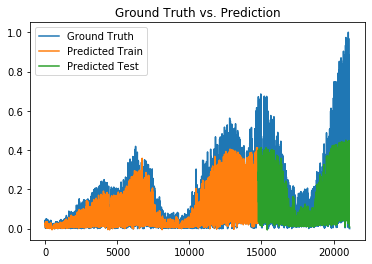

Train loss: 0.0009, Test loss: 0.0034
2H
(10461, 20) (4184, 20) (6277, 20)
(10561, 40, 14) (10561,)
(7392, 40, 14) (7392,)
(3169, 40, 14) (3169,)


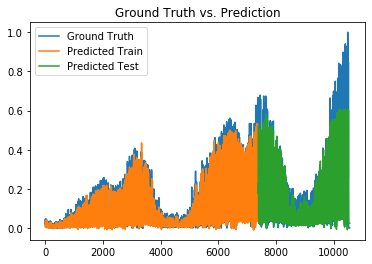

Train loss: 0.0014, Test loss: 0.0039
3H
(10461, 20) (4184, 20) (6277, 20)
(7041, 40, 14) (7041,)
(4928, 40, 14) (4928,)
(2113, 40, 14) (2113,)


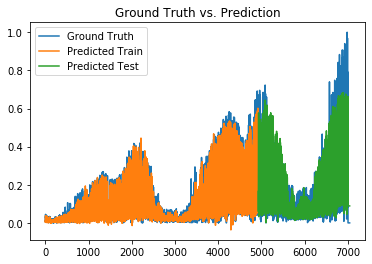

Train loss: 0.0016, Test loss: 0.0043
4H
(10461, 20) (4184, 20) (6277, 20)
(5281, 40, 14) (5281,)
(3696, 40, 14) (3696,)
(1585, 40, 14) (1585,)


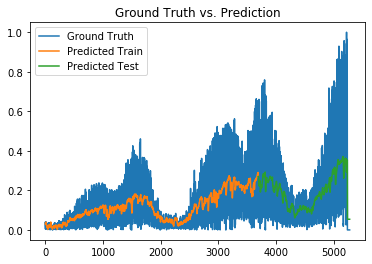

Train loss: 0.0082, Test loss: 0.0222
5H
(10461, 20) (4184, 20) (6277, 20)
(4225, 40, 14) (4225,)
(2957, 40, 14) (2957,)
(1268, 40, 14) (1268,)


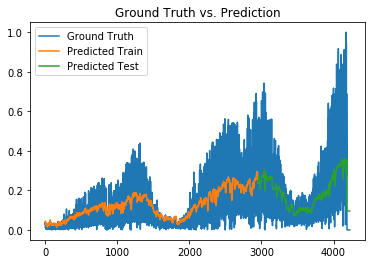

Train loss: 0.0075, Test loss: 0.0195
6H
(10461, 20) (4184, 20) (6277, 20)
(3521, 40, 14) (3521,)
(2464, 40, 14) (2464,)
(1057, 40, 14) (1057,)


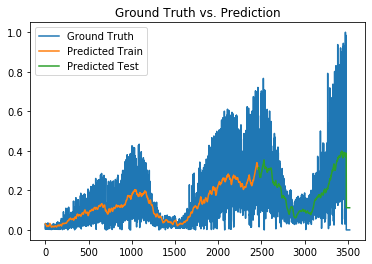

Train loss: 0.0101, Test loss: 0.0245
7H
(10461, 20) (4184, 20) (6277, 20)
(3018, 40, 14) (3018,)
(2112, 40, 14) (2112,)
(906, 40, 14) (906,)


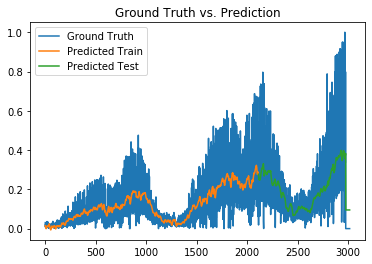

Train loss: 0.0091, Test loss: 0.0230
8H
(10461, 20) (4184, 20) (6277, 20)
(2641, 40, 14) (2641,)
(1848, 40, 14) (1848,)
(793, 40, 14) (793,)


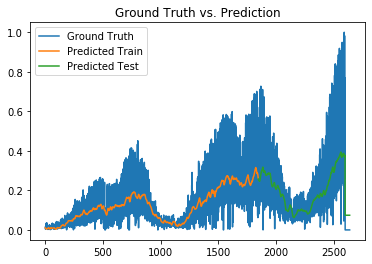

Train loss: 0.0109, Test loss: 0.0270
9H
(10461, 20) (4184, 20) (6277, 20)
(2347, 40, 14) (2347,)
(1642, 40, 14) (1642,)
(705, 40, 14) (705,)


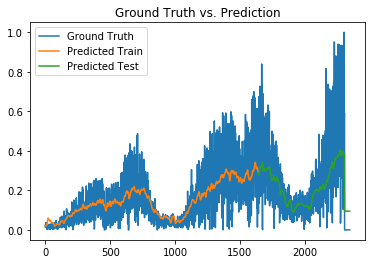

Train loss: 0.0090, Test loss: 0.0247
10H
(10461, 20) (4184, 20) (6277, 20)
(2113, 40, 14) (2113,)
(1479, 40, 14) (1479,)
(634, 40, 14) (634,)


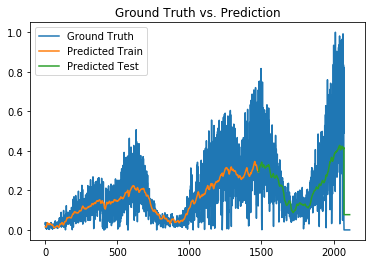

Train loss: 0.0101, Test loss: 0.0258


In [52]:
def minmax_normalize_columnwise(input_pd):
    output_np = np.zeros((input_pd.shape[0], input_pd.shape[1]))
    for c in range(input_pd.shape[1]):
        col_min, col_max = np.min(input_pd.iloc[:, c]), np.max(input_pd.iloc[:, c])
        output_np[:, c] = input_pd.iloc[:, c]
        output_np[:, c] -= col_min
        output_np[:, c] /= (col_max-col_min)
    return output_np
time_resolution = range(1, 11)
for tr in time_resolution:
    tr = str(tr)+'H'
    print(tr)
    # Load Dataset
    train, validation, test = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_train_timeseries.pkl'), pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_val_timeseries.pkl'), pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_test_timeseries.pkl')
    print(train.shape, validation.shape, test.shape)
    # Normalize Dataset
    dataset = pd.concat((train, validation, test), axis=0)
    drop_cols = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM25']
    dataset = dataset.drop(drop_cols, axis=1)
    dataset = dataset.resample(tr).sum()
    dataset_norm = minmax_normalize_columnwise(dataset)
    # Preprocessing: Sliding-window
    window_size = 40
    n_window = dataset.shape[0]-window_size+1
    X, Y = np.zeros((dataset.shape[0], window_size, dataset.shape[1])), np.zeros((dataset.shape[0],))
    for r in range(n_window-1):
        X[r], Y[r] = dataset_norm[r:r+window_size], dataset_norm[r+window_size, -1]
    print(X.shape, Y.shape)
    # Split Tr, Te
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    # Build Deeper Model
    c_input = Input(shape=(X.shape[1],X.shape[2]))
    H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
    H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
    H = TimeDistributed(MaxPooling1D(2))(H)
    H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
    H = TimeDistributed(MaxPooling1D(2))(H)
    H = TimeDistributed(Flatten())(H)
    H = Dropout(0.75)(H)
    H = CuDNNLSTM(128, return_sequences=True)(H)
    H = CuDNNLSTM(128, return_sequences=False)(H)
    H = Dropout(0.75)(H)
    H = Dense(128, activation='tanh')(H)
    H = Dense(64, activation='tanh')(H)
    c_output = Dense(1, activation='tanh')(H)
    model_cnn_lstm = Model(c_input, c_output)
#     model_cnn_lstm.summary()
    model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
    model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])
    # Train Model
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
    train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=500, callbacks=[es], verbose=0, shuffle=True)
    # Validation
    # Curve
#     plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
#     plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
    # Prediction
    Y_train_hat = model_cnn_lstm.predict(X_train, batch_size=500)
    Y_test_hat = model_cnn_lstm.predict(X_test, batch_size=500)
    plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
    plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
    plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
    plt.legend(loc='upper left')
    plt.title('Ground Truth vs. Prediction')
    plt.show()
    print("Train loss: %.4f, Test loss: %.4f" %(train_history.history['loss'][-1], train_history.history['val_loss'][-1]))